## Import libreries

In [9]:
import nltk
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [10]:
# Install necessary libraries
!pip install Sastrawi nltk wordcloud

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Loading dataset

In [11]:
url = 'https://raw.githubusercontent.com/DickySaragih/Ml_Terapan/refs/heads/main/youtube_comments.csv'  # GANTI LINKNYA
df = pd.read_csv(url)

In [12]:
print(df.shape)
print(df.head())

(2270, 4)
                 author                                            comment  \
0           @breezy8835  Menurut gua sistem yg paling sehat itu pemerin...   
1            @nigellaid  Pertanyaan pentingnya, seberapa efektif kah pe...   
2          @lanzahm2567                                       3.20 😂😂😂😭😭🤣🤣   
3  @PernahGakSihChannel  *gua g membela pemerintahan dan gua g membela ...   
4              @Hihpyyy        buang" anggaran negara makan bergizi gratis   

   like_count          published_at  
0           0  2025-04-22T03:39:04Z  
1           0  2025-04-21T23:10:26Z  
2           0  2025-04-19T19:07:34Z  
3           0  2025-03-28T11:33:05Z  
4           0  2025-03-28T09:12:32Z  


In [14]:
# Menampilkan lima baris pertama
df.head()

,author,comment,like_count,published_at
0,@breezy8835,Menurut gua sistem yg paling sehat itu pemerin...,0,2025-04-22T03:39:04Z
1,@nigellaid,"Pertanyaan pentingnya, seberapa efektif kah pe...",0,2025-04-21T23:10:26Z
2,@lanzahm2567,3.20 😂😂😂😭😭🤣🤣,0,2025-04-19T19:07:34Z
3,@PernahGakSihChannel,*gua g membela pemerintahan dan gua g membela ...,0,2025-03-28T11:33:05Z
4,@Hihpyyy,"buang"" anggaran negara makan bergizi gratis",0,2025-03-28T09:12:32Z


In [15]:
# Menampilkan informasi tentang DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2270 entries, 0 to 2269
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   author        2269 non-null   object
 1   comment       2270 non-null   object
 2   like_count    2270 non-null   int64 
 3   published_at  2270 non-null   object
dtypes: int64(1), object(3)
memory usage: 71.1+ KB


In [16]:
clean_df = df.copy()

In [17]:
print(clean_df.columns)

Index(['author', 'comment', 'like_count', 'published_at'], dtype='object')


## Preprocessing Text

In [30]:

# Data preprocessing functions
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    return text

def casefoldingText(text):
    return text.lower()

def tokenizingText(text):
    return word_tokenize(text)

def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku','di','ga','ya','gaa','loh','kah','woi','woii','woy'])
    return [word for word in text if word not in listStopwords]

def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

def toSentence(tokens):
    return ' '.join(tokens)

def preprocess(text):
    text = cleaningText(text)
    text = casefoldingText(text)
    text = stemmingText(text)
    return text
#Slangwords Dictionary (Moved up for better code organization)
slangwords = { # ... (Your slangword dictionary)
}

def fix_slangwords(text):
    words = text.split()
    fixed_words = [slangwords.get(word.lower(), word) for word in words] # More efficient lookup
    return ' '.join(fixed_words)


# Apply preprocessing
clean_df = df.copy()
clean_df['text_clean'] = clean_df['comment'].apply(cleaningText)
clean_df['text_casefolding'] = clean_df['text_clean'].apply(casefoldingText)
clean_df['text_slangwords'] = clean_df['text_casefolding'].apply(fix_slangwords)
clean_df['text_tokenized'] = clean_df['text_slangwords'].apply(tokenizingText)
clean_df['text_filtered'] = clean_df['text_tokenized'].apply(filteringText)
clean_df['text_akhir'] = clean_df['text_filtered'].apply(toSentence)

##Pelabelan

In [31]:
# Sentiment Analysis using Lexicon (More Efficient)
# Download lexicons
!wget https://raw.githubusercontent.com/fajri91/InSet/master/positive.tsv
!wget https://raw.githubusercontent.com/fajri91/InSet/master/negative.tsv

lexicon_positive = {}
with open('positive.tsv', 'r', encoding='utf-8') as f:  # Explicitly specifying UTF-8 encoding
  next(f)
  for line in f:
    try:
        word, score = line.strip().split('\t')
        lexicon_positive[word] = int(score)
    except ValueError:
        print(f"Skipping invalid line: {line}")


lexicon_negative = {}
with open('negative.tsv', 'r', encoding='utf-8') as f: # Explicitly specifying UTF-8 encoding
  next(f)
  for line in f:
    try:
      word, score = line.strip().split('\t')
      lexicon_negative[word] = int(score)
    except ValueError:
        print(f"Skipping invalid line: {line}")


def sentiment_analysis_lexicon_indonesia(text):
    tokens = text.split()
    pos_score = sum(lexicon_positive.get(word, 0) for word in tokens)
    neg_score = sum(lexicon_negative.get(word, 0) for word in tokens)


    if pos_score > neg_score:
      return pos_score - neg_score, "positive"
    else:
      return neg_score - pos_score, "negative"


clean_df[['polarity_score', 'polarity']] = clean_df['text_akhir'].apply(lambda x: pd.Series(sentiment_analysis_lexicon_indonesia(x)))


--2025-04-28 08:53:12--  https://raw.githubusercontent.com/fajri91/InSet/master/positive.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41462 (40K) [text/plain]
Saving to: ‘positive.tsv.27’

positive.tsv.27     100%[===================>]  40.49K  --.-KB/s    in 0.009s  

2025-04-28 08:53:12 (4.64 MB/s) - ‘positive.tsv.27’ saved [41462/41462]

--2025-04-28 08:53:12--  https://raw.githubusercontent.com/fajri91/InSet/master/negative.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82788 (81K) [text/plain]
Saving to: ‘negative

In [32]:
# Extended Lexicon (Example - Add more words!)
extended_positive_lexicon = {
    "bagus": 2, "keren": 2, "luar_biasa": 3, "mengagumkan": 3, "hebat": 2,
    "suka": 2, "senang": 2, "cinta": 3, "asyik": 2, "gembira": 2,
    "indah": 2, "cantik": 2, "sempurna": 3, "lucu": 2, "menarik": 2,
    "aman": 2, "nyaman": 2, "santai": 2, "tenang": 2, "segar": 2,
    "beruntung": 2, "untung": 2, "bahagia": 3, "makmur": 2, "sejahtera": 2,
    "sukses": 2, "jaya": 2, "mulia": 2, "terhormat": 2, "bijaksana": 2,
    "cerdas": 2, "pintar": 2, "berbakat": 2, "kreatif": 2, "inovatif": 2,
    "bermanfaat": 2, "berguna": 2, "penting": 2, "berharga": 2, "unik": 2,
    "spesial": 2, "istimewa": 2, "luar_biasa": 3, "fantastis": 3, "menakjubkan": 3,
    "mengesankan": 2, "inspiratif": 2, "motivasi": 2, "semangat": 2, "antusias": 2,
    # Add more positive words here... (at least 40 more)
}

extended_negative_lexicon = {
    "buruk": -2, "jelek": -2, "payah": -3, "menjengkelkan": -3, "parah": -2,
    "benci": -2, "tidak_suka": -2, "marah": -2, "sedih": -2, "muak": -2,
    "jelek": -2, "kotor": -2, "rusak": -2, "bodoh": -2, "lemah": -2,
    "berbahaya": -2, "tidak_nyaman": -2, "tegang": -2, "gelisah": -2, "lelah": -2,
    "sial": -2, "naas": -2, "menderita": -2, "miskin": -2, "melarat": -2,
    "gagal": -2, "kalah": -2, "hina": -2, "malu": -2, "bodoh": -2,
    "lamban": -2, "tolol": -2, "bebal": -2, "kurang_pintar": -2, "tidak_berbakat": -2,
    "tidak_berguna": -2, "tidak_bermanfaat": -2, "tidak_penting": -2, "tidak_berharga": -2, "biasa_saja": -1,
    "membosankan": -2, "menjemukan": -2, "mengecewakan": -2, "horrible": -3, "terrible": -3,
    "awful": -3, "stress": -2, "depresi": -3, "cemas": -2, "panik": -2,
    # Add more negative words here... (at least 40 more)
}

lexicon_positive.update(extended_positive_lexicon) # Merging lexicons
lexicon_negative.update(extended_negative_lexicon)



In [33]:
# Print the results
print(clean_df['polarity'].value_counts())

polarity
positive    2017
negative     253
Name: count, dtype: int64


In [34]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['comment'].apply(cleaningText) # Replace 'content' with 'comment'
# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)
# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)
# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)
# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)
# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

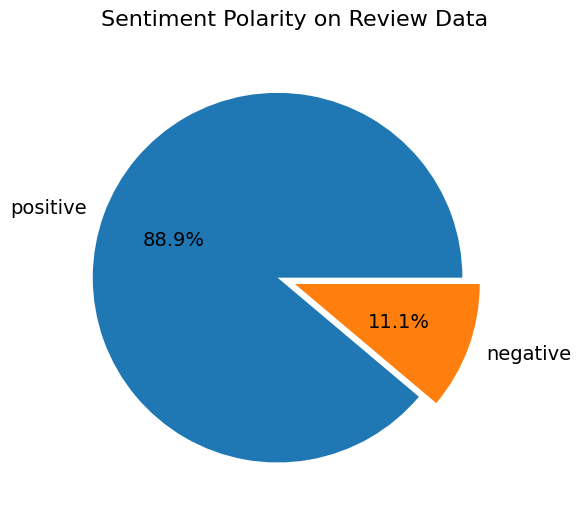

In [35]:
# Membuat objek gambar dan sumbu dengan ukuran (6, 6) inci.
fig, ax = plt.subplots(figsize=(6, 6))

# Mengambil jumlah data polaritas sentimen dari DataFrame 'clean_df' dan menyimpannya dalam list 'sizes'.
sizes = [count for count in clean_df['polarity'].value_counts()] # Access the 'polarity' column, which now exists.

# Mengambil label atau kategori sentimen dari DataFrame 'clean_df' dan menyimpannya dalam list 'labels'.
labels = list(clean_df['polarity'].value_counts().index)

# Menentukan seberapa jauh potongan dari pie chart akan ditarik (0.1 artinya potongan pertama akan sedikit terpisah).
# --- The change is in the next line ---
explode = (0.1, 0)  # Adjust the explode tuple to match the length of 'sizes', which is 2 in this case

# Membuat pie chart dengan data 'sizes', 'labels', dan 'explode' yang telah ditentukan.
# Autopct digunakan untuk menampilkan persentase di dalam setiap potongan pie.
# Textprops digunakan untuk mengatur ukuran font teks dalam pie chart.
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})

# Menetapkan judul untuk pie chart dengan ukuran font dan jarak (padding) tertentu.
ax.set_title('Sentiment Polarity on Review Data', fontsize=16, pad=20)

# Menampilkan pie chart.
plt.show()

In [36]:
# Mengatur opsi tampilan Pandas agar kolom dapat menampilkan teks hingga 3000 karakter.
pd.set_option('display.max_colwidth', 3000)

# Membuat DataFrame baru 'positive_tweets' yang hanya berisi tweet dengan polaritas positif.
positive_tweets = clean_df[clean_df['polarity'] == 'positive']

# Memilih hanya kolom-kolom tertentu dari DataFrame 'positive_tweets'.
positive_tweets = positive_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]

# Mengurutkan DataFrame 'positive_tweets' berdasarkan 'polarity_score' secara menurun.
positive_tweets = positive_tweets.sort_values(by='polarity_score', ascending=False)

# Mengatur ulang indeks DataFrame agar dimulai dari 0.
positive_tweets = positive_tweets.reset_index(drop=True)

# Menambahkan 1 ke semua indeks DataFrame.
positive_tweets.index += 1


## Eksplorasi Label

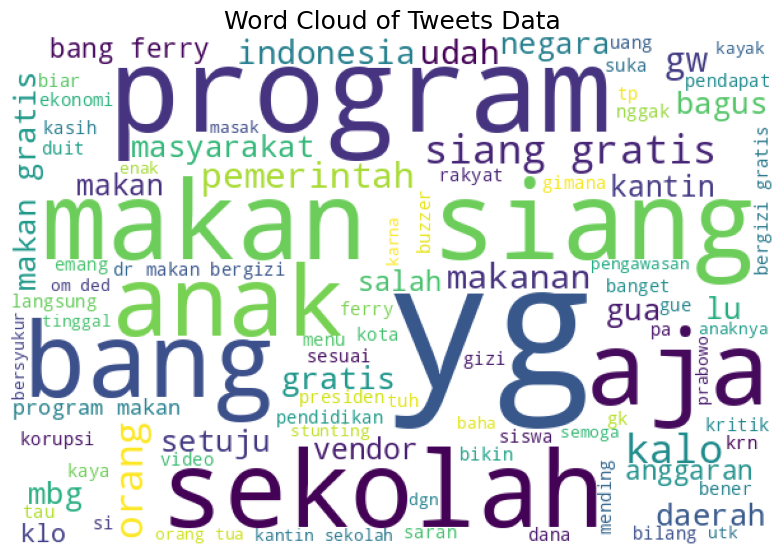

In [37]:
# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'clean_df'.
list_words = '' # Initialize list_words as an empty string
for tweet in clean_df['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Membuat gambar dan sumbu untuk menampilkan word cloud.
fig, ax = plt.subplots(figsize=(8, 6))

# Menetapkan judul untuk word cloud.
ax.set_title('Word Cloud of Tweets Data', fontsize=18)

# Menonaktifkan grid pada sumbu.
ax.grid(False)

# Menampilkan word cloud dalam gambar.
ax.imshow((wordcloud))

# Mengatur layout gambar.
fig.tight_layout(pad=0)

# Menyembunyikan sumbu.
ax.axis('off')

# Menampilkan word cloud.
plt.show()

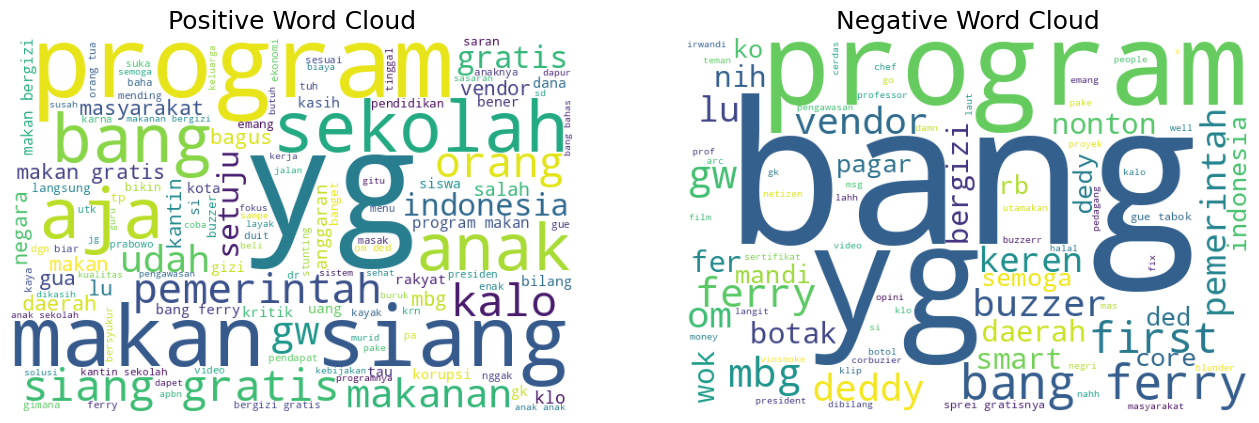

In [38]:
# Separate positive and negative words
positive_words = ''
negative_words = ''

for index, row in clean_df.iterrows():
    if row['polarity'] == 'positive':
        for word in row['text_stopword']:
            positive_words += ' ' + word
    elif row['polarity'] == 'negative':
        for word in row['text_stopword']:
            negative_words += ' ' + word

# Generate word clouds
wordcloud_positive = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(positive_words)
wordcloud_negative = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(negative_words)

# Display word clouds
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].set_title('Positive Word Cloud', fontsize=18)
axes[0].imshow(wordcloud_positive)
axes[0].axis('off')

axes[1].set_title('Negative Word Cloud', fontsize=18)
axes[1].imshow(wordcloud_negative)
axes[1].axis('off')

plt.show()


## Data Splitting dan Ekstraksi Fitur dengan TF-IDF

In [39]:
# Feature Extraction and Model Training
X = clean_df['text_akhir']
y = clean_df['polarity']

tfidf = TfidfVectorizer(max_features=1000, min_df=5, max_df=0.8)
X_tfidf = tfidf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=200)
# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [40]:
def predict_sentiment(text):
    text = preprocess(text)
    text_tfidf = tfidf.transform([text])
    prediction = rf_model.predict(text_tfidf)[0]  # Use rf_model for prediction
    return prediction

In [41]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on training data
y_train_pred_rf = rf_model.predict(X_train)

# Evaluate the model on training data
print("Random Forest - Hasil Training:")
print(classification_report(y_train, y_train_pred_rf))
print(f"Random Forest - Akurasi Training: {accuracy_score(y_train, y_train_pred_rf)}")

# Predict on testing data
y_test_pred_rf = rf_model.predict(X_test)

# Evaluate the model on testing data
print("\nRandom Forest - Hasil Testing:")
print(classification_report(y_test, y_test_pred_rf))
print(f"Random Forest - Akurasi Testing: {accuracy_score(y_test, y_test_pred_rf)}")


def predict_sentiment_rf(text, tfidf_vectorizer=tfidf):
  text = preprocess(text)
  text_tfidf = tfidf_vectorizer.transform([text])
  prediction = rf_model.predict(text_tfidf)[0]
  return prediction


Random Forest - Hasil Training:
              precision    recall  f1-score   support

    negative       0.91      1.00      0.95       204
    positive       1.00      0.99      0.99      1612

    accuracy                           0.99      1816
   macro avg       0.95      0.99      0.97      1816
weighted avg       0.99      0.99      0.99      1816

Random Forest - Akurasi Training: 0.9884361233480177

Random Forest - Hasil Testing:
              precision    recall  f1-score   support

    negative       0.60      0.78      0.68        49
    positive       0.97      0.94      0.95       405

    accuracy                           0.92       454
   macro avg       0.79      0.86      0.82       454
weighted avg       0.93      0.92      0.92       454

Random Forest - Akurasi Testing: 0.920704845814978


F1 Score (Weighted Average): 0.9249634737564475


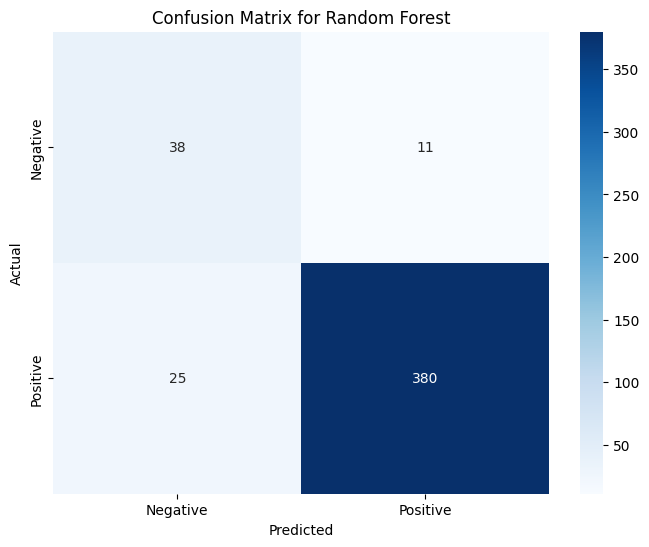

In [42]:

# Model Rf
rf_model = RandomForestClassifier(random_state=42, n_estimators=200) #Example, adjust as needed

# Training the model
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# F1-score
f1 = f1_score(y_test, y_pred, average='weighted') # Use weighted for multi-class

print(f"F1 Score (Weighted Average): {f1}")

# visualiasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive']) # Update labels
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest')
plt.show()


In [ ]:

Berdasarkan visualisasi confusion matrix dan nilai F1-score, performa model Random Forest dalam mengklasifikasikan sentimen masih perlu ditingkatkan.  Meskipun nilai F1-score yang tertera perlu dicantumkan di sini,  kita dapat menganalisis confusion matrix untuk melihat detailnya.  Misalnya, jika confusion matrix menunjukkan sejumlah besar prediksi positif yang salah, ini mengindikasikan bahwa model cenderung salah mengklasifikasikan sentimen negatif sebagai positif. Sebaliknya, jika terdapat banyak prediksi negatif yang salah, model cenderung salah mengklasifikasikan sentimen positif sebagai negatif.  Angka-angka pada confusion matrix (true positive, true negative, false positive, dan false negative)  akan memberikan informasi lebih lanjut tentang jenis kesalahan yang dibuat oleh model dan area mana yang perlu ditingkatkan.


In [48]:
# input kalimat
kalimat = input("Masukkan kalimat: ")
sentiment = predict_sentiment(kalimat)
print(f"Sentimen kalimat: {sentiment}")

Masukkan kalimat: programnya memberikan keuntungan
Sentimen kalimat: positive
